In [47]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

## Use the Labeled Faces in the Wild dataset

In [1]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


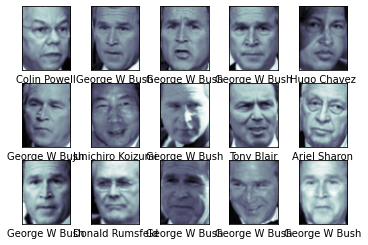

In [36]:
# plot a 3 rows by 5 columns figure
fig, ax = plt.subplots(3,5)

for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

Each image contains [62 x 47] or close to 3000 pixels. Instead of using each pixel value as a feature, we will use PCA as a preprocessor to extract more meaningful features. After which, we will feed about 150 fundamental components into the SVM.

In [11]:
# extract 150 components from PCA
pca = PCA(n_components=150, whiten=True, random_state=42)

# feed components into Support Vector Classifier
svc = SVC(kernel='rbf', class_weight='balanced')

model = make_pipeline(pca, svc)

In [17]:
# split data into training and testing set
X_train, X_test, y_train, y_test =\
train_test_split(faces.data, faces.target, test_size=0.3, random_state=42)

The hyperparameters of the SVC
1. C: controls the margin hardness
2. gamma: controls the size of the radial basis function kernel (rbf)

In [28]:
# use grid search cross validation to explore parameters combination
# tune the C and gamma parameter for the SVC

param_grid = {'svc__C': [1,5,10,50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}

grid = GridSearchCV(model, param_grid, n_jobs=-1)
%time grid.fit(X_train, y_train)
print(grid.best_params_)

Wall time: 6.6 s
{'svc__C': 5, 'svc__gamma': 0.001}


Seeing that te optimal values are somewhere in the middle of the grid, we can continue with the next step. If however the best params values are at the edge, we would have to expand the grid to ensure that we have found the true optimum.

In [29]:
# Using the model to predict labels for the test data
model = grid.best_estimator_
pred = model.predict(X_test)

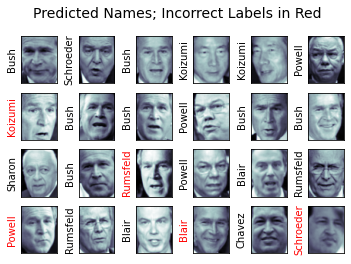

In [37]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(X_test[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    
    # set ylabel of each subplot with the predicted name
    axi.set_ylabel(faces.target_names[pred[i]].split()[-1],
    color='black' if pred[i] == y_test[i] else 'red')
    
    # set title of plot
    fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

Out of 24 faces, there were 5 wrongly classified ones. We can use the classification report to evaluate the model's performance.

In [40]:
print(classification_report(y_test, pred, target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.68      0.88      0.77        17
     Colin Powell       0.80      0.86      0.83        84
  Donald Rumsfeld       0.67      0.89      0.76        36
    George W Bush       0.91      0.77      0.83       146
Gerhard Schroeder       0.70      0.75      0.72        28
      Hugo Chavez       0.89      0.63      0.74        27
Junichiro Koizumi       0.79      0.94      0.86        16
       Tony Blair       0.72      0.76      0.74        51

         accuracy                           0.80       405
        macro avg       0.77      0.81      0.78       405
     weighted avg       0.81      0.80      0.80       405



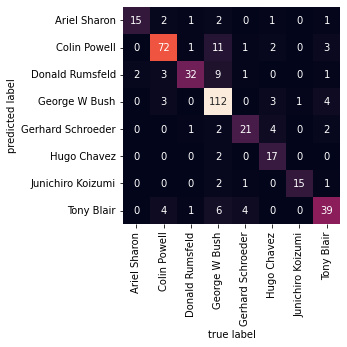

In [52]:
mat = confusion_matrix(y_test, pred)

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

Plotting the confusion matrix gives us a better visual of which labels are misrepresented by the estimator. We would likely need more sophisticated models are photos are not so nicely cropped out in the real world.

## Summary of the SVM algorithm

SVMs are a powerful classification method. They are compact models and take up very little memory. Once the model is trained, predictions can occur very quickly.

Because SVMs are affected only by points near the margin, they tend to work well with high dimensional data. Most other algorithms fit poorly when there are more features than data samples.

However results are dependent on the choice of C, which must be chosen properly through cross-validation. As datasets grow, the computational cost is expensive.

Generally, SVMS are used only when simpler and faster methods are insufficient. Otherwise this algorithm tends to give good results.